In [1]:
from credit.data import get_forward_data
from glob import glob
import os
import xarray as xr
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from os.path import join
from credit.xr_sampler import XRSamplerByYear
import yaml

In [3]:
eval_fh = 48
variable, level = "U", 24

rollout_dir = "/glade/derecho/scratch/dkimpara/CREDIT_runs/skebs_diss_train"
rollout_files = glob(join(rollout_dir, f"2012*/*{eval_fh:03}.nc")) + glob(join(rollout_dir, f"2013*/*{eval_fh:03}.nc"))


#### debug option

In [3]:
# rollout_files = rollout_files[:2]

## concat data

In [2]:
with open("/glade/derecho/scratch/dkimpara/CREDIT_runs/skebs_diss_train/model.yml") as cf:
    conf = yaml.load(cf, Loader=yaml.FullLoader)

sampler = XRSamplerByYear(conf)

def select_darray(ds_given):
    ds_sel = ds_given[variable]
    if variable in "UVTQtot":
        return ds_sel.isel(level=level)
    return ds_sel


# get pred and true data
pred_da_list = []
true_da_list = []
for file in rollout_files:
    ds = xr.open_dataset(file)
    da = select_darray(ds)
    pred_da_list.append(da)
    
    da_true = select_darray(sampler(da.time.values[0]))
    true_da_list.append(da_true)

da_pred = xr.concat(pred_da_list, dim='time')
da_true = xr.concat(true_da_list, dim='time')
return da_pred, da_true

# rank histogram

In [ ]:
from xskillscore import rank_histogram

In [8]:
rh = rank_histogram(da_true, da_pred, member_dim="ensemble_member_label")

In [9]:
rh.values

array([36282, 33478, 35953, 38098, 40790, 43361, 44422, 45043, 46025,
       46610, 45779, 45389, 44802, 43763, 42412, 41758, 39866, 38179,
       36772, 35541, 33972, 32141, 31027, 29335, 27958, 26462, 24739,
       23638, 22378, 20931, 19937, 18926, 17693, 16429, 15823, 14895,
       13712, 12819, 11957, 11255, 10394,  9880,  9094,  8502,  7944,
        7257,  6682,  6680, 10321])

NameError: name 'tropics_only' is not defined

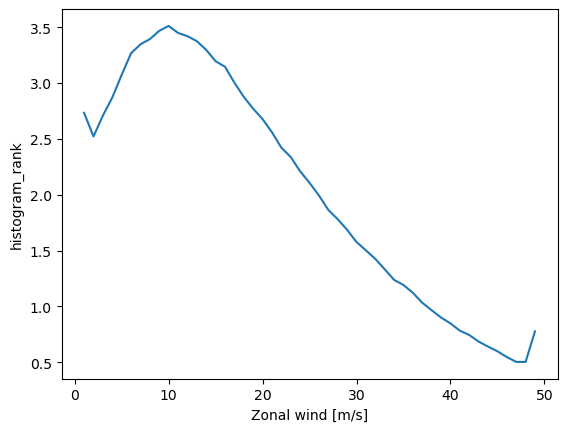

In [10]:
(rh / rh.sum() * 100).plot()
plt.title(f"{eval_fh}hr {variable}{level if variable in 'UVTQtot' else ''}")
plt.xlabel("rank")
plt.ylabel("percentage")
plt.ylim(0,12)

In [ ]:
tropics_only = True
da_pred = da_pred.sel(latitude=slice(-24, 24))
da_true = da_true.sel(latitude=slice(-24, 24))

rh = rank_histogram(da_true, da_pred, member_dim="ensemble_member_label")
(rh / rh.sum() * 100).plot()
plt.title(f"{eval_fh}hr {variable}{level if variable in 'UVTQtot' else ''}{' tropics' if tropics_only else ''}")
plt.xlabel("rank")
plt.ylabel("percentage")
plt.ylim(0,12)